# Generating Masks and Presence Predictions

### Imports

In [1]:
%cd ..
%pwd

!pip install tensorflow

/home/jovyan/AI-Event-Monitoring


In [2]:
import os
import numpy             as np
import matplotlib.pyplot as plt

os.environ['TF_CPP_MIN_LOG_LEVEL'] = '3'

plt.rcParams['figure.figsize']  = (20,10)

from tensorflow.keras.models  import load_model
from osgeo                    import gdal
from PIL                      import Image
from math                     import ceil
from typing                   import Tuple

from insar_eventnet.io        import get_image_array
from insar_eventnet.inference import mask_with_model, plot_results

%cd notebooks
%pwd

/home/jovyan/AI-Event-Monitoring/notebooks


'/home/jovyan/AI-Event-Monitoring/notebooks'

### Initialize Variables

In [3]:
tile_size = 512
crop_size = 512

mask_model_path = 'models/masking_model'
pres_model_path = 'models/classification_model'
image_path      = input('Image Path: ')
image_name      = image_path.split('/')[-1].split('.')[0]
output_path     = f'masks_inferred/{image_name}_mask.tif'

mask_model = load_model(mask_model_path)
pres_model = load_model(pres_model_path)

is_wrapped = False

if is_wrapped:
    wrapped, gdal_dataset = get_image_array(image_path)
else:
    unwrapped, gdal_dataset = get_image_array(image_path)
    wrapped      = np.angle(np.exp(1j * (unwrapped)))

Image Path:  SAR_DATA/Positives/S1BA_20210303T162334_20210309T162415_VVR006_INT80_G_ueF_D75C_unw_phase.tif


The dtype policy mixed_float16 may run slowly because this machine does not have a GPU. Only Nvidia GPUs with compute capability of at least 7.0 run quickly with mixed_float16.
If you will use compatible GPU(s) not attached to this host, e.g. by running a multi-worker model, you can ignore this warning. This message will only be logged once


/home/jovyan/.local/envs/rtc_analysis/lib/python3.9/site-packages/osgeo/gdal.py:287: FutureWarning: Neither gdal.UseExceptions() nor gdal.DontUseExceptions() has been explicitly called. In GDAL 4.0, exceptions will be enabled by default.
  warnings.warn(


### Inference on a Single Wrapped or Unwrapped Image

In [4]:
mask, presence_mask, presence_values = mask_with_model(
    mask_model = mask_model,
    pres_model = pres_model,
    arr_w      = wrapped,
    tile_size  = tile_size,
    crop_size  = crop_size
)

### Plot Results

Positive!


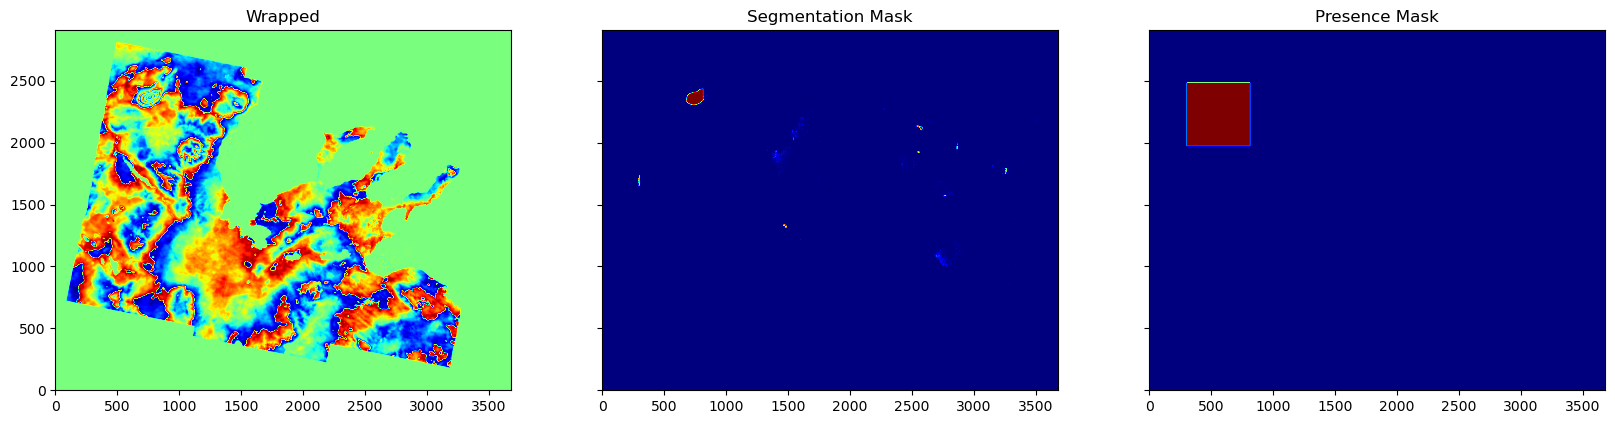

In [5]:
if np.max(presence_values) > 0.7:
    print("Positive!")
else:
    print("Negative!")

mask[unwrapped == 0] = 0

plot_results(wrapped, mask, presence_mask)

### Save with Geo-Metadata

In [6]:
if not os.path.exists('masks_inferred'):
   os.makedirs('masks_inferred')

output_img = Image.fromarray(mask)
output_img.save(output_path)

out_dataset = gdal.Open(output_path, gdal.GA_Update)
out_dataset.SetProjection(gdal_dataset.GetProjection())
out_dataset.SetGeoTransform(gdal_dataset.GetGeoTransform())
out_dataset.FlushCache()

0